In [1]:
%matplotlib inline
from hmmlearn import hmm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math
import scipy.stats as stats
import statsmodels.api as sm
import gdown


In [2]:
# Define the ticker and date range
ticker = "BBRI.JK"
start_date = "2014-01-01"
end_date = "2024-11-13"

# Fetch data
data_csv = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Reset index to make the date a regular column, not the index
data_csv = data_csv.reset_index()

# Display the first few rows to confirm
print(data_csv.tail())

# Optionally, save the data to a CSV file
data_csv.to_csv("BBRI_JK.csv", index=False)

data = data_csv[data_csv.columns[1:5]]

# Calculate 95% of the total number of rows
num_rows = int(0.95 * len(data))

# Select the first 95% of rows
obs = data.iloc[:num_rows]
# Remove any rows with missing values
obs = obs.dropna()

# Print the monthly data
print(obs)
print(data)

[*********************100%***********************]  1 of 1 completed
           Date    Open    High     Low   Close    Adj Close     Volume
2683 2024-11-06  4710.0  4730.0  4600.0  4600.0  4452.142578  249059500
2684 2024-11-07  4610.0  4640.0  4550.0  4550.0  4403.750000  296218600
2685 2024-11-08  4600.0  4640.0  4520.0  4520.0  4374.714355  198589900
2686 2024-11-11  4470.0  4540.0  4370.0  4460.0  4316.642578  507192300
2687 2024-11-12  4430.0  4520.0  4430.0  4500.0  4355.356934  252380100
             Open         High          Low        Close
0     1327.249756  1336.340576  1309.068237  1327.249756
1     1318.159058  1327.249756  1299.977539  1318.159058
2     1309.068237  1318.159058  1272.705322  1277.250610
3     1286.341431  1295.432129  1286.341431  1286.341431
4     1290.886841  1313.613647  1290.886841  1304.522949
...           ...          ...          ...          ...
2548  5350.000000  5375.000000  5250.000000  5275.000000
2549  5200.000000  5325.000000  5150.000000

In [3]:

T = 120
AIC, BIC, HQC, CAIC = [], [], [], []

for n in range(2, 7):
    a, b, c, d = [], [], [], []
    first_time = True

    for i in range(0, T):
        
        if first_time:
            model = hmm.GaussianHMM(n_components=n, init_params="stmc", n_iter=5000)
            first_time = False
        else:
            old_model = model
            model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)
            model.startprob_ = old_model.startprob_
            model.transmat_ = old_model.transmat_
            model.means_ = old_model.means_

            # Normalize startprob_ to ensure it sums to 1
            model.startprob_ = model.startprob_ / np.sum(model.startprob_)

            # Ensure transition matrix rows sum to 1
            model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

            # If any row sums to 0, reinitialize it to uniform probabilities
            for row in range(n):
                if np.sum(model.transmat_[row]) == 0:
                    model.transmat_[row] = np.full(n, 1 / n)

        # Fit the model using the data
        model.fit(obs[i:i+T])

        log_likelihoods = model.score(obs[i:i+T])
        k = n**2 + 2*n - 1

        aic = -2 * log_likelihoods + 2 * k
        bic = -2 * log_likelihoods + k * np.log(4 * T)
        hqc = -2 * log_likelihoods + k * (np.log(np.log(4 * T)))
        caic = -2 * log_likelihoods + k * (np.log(4 * T) + 1)

        a.append(aic)
        b.append(bic)
        c.append(hqc)
        d.append(caic)

    AIC.append(a)
    BIC.append(b)
    HQC.append(c)
    CAIC.append(d)


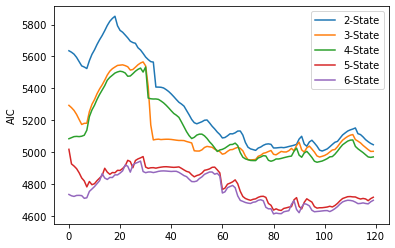

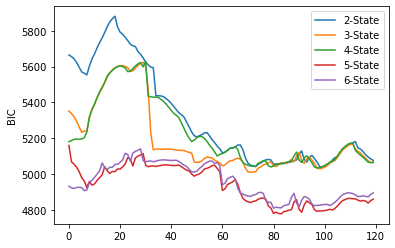

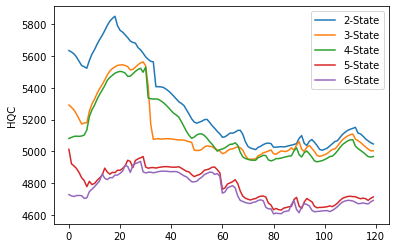

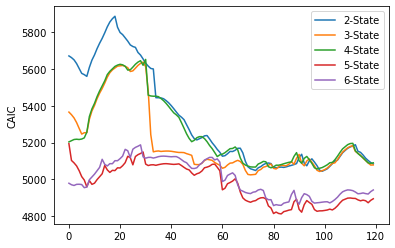

In [4]:

# Plot AIC values for different numbers of components
for i in range(0, 5):
    plt.plot(AIC[i], label=f"{i+2}-State")
plt.ylabel("AIC")
plt.legend()
plt.savefig(f"{ticker}_AIC_plot.png")  # Save the AIC plot with the ticker in the filename
plt.show()

# Plot BIC values for different numbers of components
for i in range(0, 5):
    plt.plot(BIC[i], label=f"{i+2}-State")
plt.ylabel("BIC")
plt.legend()
plt.savefig(f"{ticker}_BIC_plot.png")  # Save the BIC plot with the ticker in the filename
plt.show()

# Plot HQC values for different numbers of components
for i in range(0, 5):
    plt.plot(HQC[i], label=f"{i+2}-State")
plt.ylabel("HQC")
plt.legend()
plt.savefig(f"{ticker}_HQC_plot.png")  # Save the HQC plot with the ticker in the filename
plt.show()

# Plot CAIC values for different numbers of components
for i in range(0, 5):
    plt.plot(CAIC[i], label=f"{i+2}-State")
plt.ylabel("CAIC")
plt.legend()
plt.savefig(f"{ticker}_CAIC_plot.png")  # Save the CAIC plot with the ticker in the filename
plt.show()


In [8]:

first_time = True
obs = data.iloc[:num_rows]
n = 6
T = 120
w = int(len(obs)*0.84/0.95) - T
likelihood_list = []  

# Creating Likelihood from trained data
for i in range(0, w):
    
    if first_time:
        model = hmm.GaussianHMM(n_components=n, init_params="stmc", n_iter=5000)
        first_time = False
    else:
        old_model = model
        model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)

        # Ensure model parameters match the expected number of components
        model.startprob_ = np.zeros(n)  # Initialize with zeros
        model.transmat_ = np.zeros((n, n))  # Initialize with zeros
        model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
        if old_model.startprob_.shape[0] == n:
            model.startprob_ = old_model.startprob_
        if old_model.transmat_.shape == (n, n):
            model.transmat_ = old_model.transmat_
        if old_model.means_.shape[0] == n:
            model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
        model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
        model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
        for row in range(n):
            if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
                model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
        if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
            print("Invalid parameters detected, reinitializing...")
            model.startprob_ = np.full(n, 1 / n)
            model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[i:i+T])
    likelihoods = model.score(obs[i:i+T])
    likelihood_list.append(likelihoods)  # Append the likelihood directly


In [9]:
num_test=int(0.05*len(data))
# Select the first 95% of rows
obs = data.iloc[:num_rows]
# Remove any rows with missing values
obs = obs.dropna()

for i in range (num_test) :
    old_model = model
    model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)

    # Ensure model parameters match the expected number of components
    model.startprob_ = np.zeros(n)  # Initialize with zeros
    model.transmat_ = np.zeros((n, n))  # Initialize with zeros
    model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
    if old_model.startprob_.shape[0] == n:
        model.startprob_ = old_model.startprob_
    if old_model.transmat_.shape == (n, n):
        model.transmat_ = old_model.transmat_
    if old_model.means_.shape[0] == n:
        model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
    model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
    model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
    for row in range(n):
        if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
            model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
    if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
        print("Invalid parameters detected, reinitializing...")
        model.startprob_ = np.full(n, 1 / n)
        model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[w+i:w+i+T])
    curr_likelihood = model.score(obs[w+i:w+i+T])
    # Initialize variables to track the minimum difference and corresponding index
    min_diff = float('inf')  # Start with infinity for the minimum difference
    min_index = -1           # Initialize index for the minimum difference

    # Step 1: Loop through the likelihood_list
    for k, likelihood in enumerate(likelihood_list):
        diff = abs(curr_likelihood - likelihood)  # Calculate the absolute difference
    
        # Step 2: Check if this is the smallest difference
        if diff < min_diff:
            min_diff = diff  # Update the minimum difference
            min_index = k    # Update the index of the closest likelihood

    # Step 3: Get the corresponding likelihood value
    closest_likelihood = likelihood_list[min_index]
    row_values1 = obs.iloc[min_index + T]
    row_values2 = obs.iloc[min_index + T+1]
    
    # Calculate the next day price
    close_price = obs['Close'].iloc[-1] + (( row_values2['Close'] -  row_values1['Close']) * np.sign(curr_likelihood - closest_likelihood))
    open_price = obs['Open'].iloc[-1] + (( row_values2['Open'] - row_values1['Open']) * np.sign(curr_likelihood - closest_likelihood))
    high_price = obs['High'].iloc[-1] + (( row_values2['High'] -  row_values1['High']) * np.sign(curr_likelihood - closest_likelihood))
    low_price = obs['Low'].iloc[-1] + (( row_values2['Low']-  row_values1['Low']) * np.sign(curr_likelihood - closest_likelihood))

    new_row = {'Open': open_price, 'High': high_price, 'Low': low_price, 'Close': close_price}
    new_row_df = pd.DataFrame([new_row])  # Create a DataFrame from the dictionary
    obs = pd.concat([obs, new_row_df], ignore_index=True)
    
    # Step 4: Display the result
    print(f" iteration {i}The closest likelihood value to {curr_likelihood} is {closest_likelihood} at index {min_index}.")


 iteration 0The closest likelihood value to -3061.8860674027947 is -3061.819069349986 at index 1425.
 iteration 1The closest likelihood value to -3059.534562325334 is -3059.76889726105 at index 1269.
 iteration 2The closest likelihood value to -3056.125736225738 is -3056.1476445315216 at index 1423.
 iteration 3The closest likelihood value to -3052.172700049132 is -3052.170041184625 at index 1260.
 iteration 4The closest likelihood value to -3047.817801350091 is -3047.816649407998 at index 771.
 iteration 5The closest likelihood value to -3043.812103473041 is -3043.9645856449542 at index 884.
 iteration 6The closest likelihood value to -3039.4054719295336 is -3039.4680210360716 at index 1110.
 iteration 7The closest likelihood value to -3034.0475051350145 is -3033.7185415776094 at index 1414.
 iteration 8The closest likelihood value to -3028.0141913268226 is -3027.942146324576 at index 728.
 iteration 9The closest likelihood value to -3022.291398873687 is -3021.811037526795 at index 87

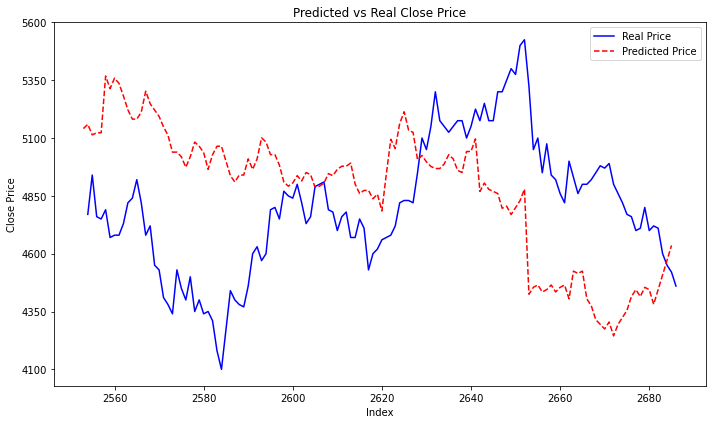

In [10]:
import matplotlib.pyplot as plt

# Assuming num_test is defined
predicted_price = obs["Close"].iloc[-(num_test):-1]
real_price = data["Close"].iloc[-(num_test):-1]

# Plot predicted vs real prices
plt.figure(figsize=(10, 6))

# Plot real prices
plt.plot(real_price.index, real_price, label='Real Price', color='blue')

# Plot predicted prices
plt.plot(predicted_price.index, predicted_price, label='Predicted Price', color='red', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Predicted vs Real Close Price')
plt.legend()

# Set y-axis ticks with a step of 500
plt.yticks(range(int(real_price.min()), int(real_price.max()) + 250, 250))
plt.savefig(f"{ticker}_Prediction_plot.png")
# Show plot
plt.tight_layout()
plt.show()


In [11]:
mape = (abs((real_price - predicted_price) / real_price)).mean() * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")

Mean Absolute Percentage Error (MAPE): 8.275%


In [12]:
real_price

2554    4770.0
2555    4940.0
2556    4760.0
2557    4750.0
2558    4790.0
         ...  
2682    4710.0
2683    4600.0
2684    4550.0
2685    4520.0
2686    4460.0
Name: Close, Length: 133, dtype: float64

In [13]:
predicted_price

2553    5140.909180
2554    5159.090332
2555    5113.636719
2556    5122.727539
2557    5122.727539
           ...     
2681    4380.928345
2682    4444.563599
2683    4508.198853
2684    4571.834106
2685    4635.469360
Name: Close, Length: 133, dtype: float64

In [14]:
#Out of Sample

first_time = True
obs = data
n = 6
T = 120
w = int(len(obs)*0.95/0.95) - T
likelihood_list = []  

# Creating Likelihood from trained data
for i in range(0, w):
    
    if first_time:
        model = hmm.GaussianHMM(n_components=n, init_params="stmc", n_iter=5000)
        first_time = False
    else:
        old_model = model
        model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)

        # Ensure model parameters match the expected number of components
        model.startprob_ = np.zeros(n)  # Initialize with zeros
        model.transmat_ = np.zeros((n, n))  # Initialize with zeros
        model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
        if old_model.startprob_.shape[0] == n:
            model.startprob_ = old_model.startprob_
        if old_model.transmat_.shape == (n, n):
            model.transmat_ = old_model.transmat_
        if old_model.means_.shape[0] == n:
            model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
        model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
        model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
        for row in range(n):
            if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
                model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
        if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
            print("Invalid parameters detected, reinitializing...")
            model.startprob_ = np.full(n, 1 / n)
            model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[i:i+T])
    likelihoods = model.score(obs[i:i+T])
    likelihood_list.append(likelihoods)  # Append the likelihood directly


In [15]:
obs=data
for i in range (num_test) :
    old_model = model
    model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)

    # Ensure model parameters match the expected number of components
    model.startprob_ = np.zeros(n)  # Initialize with zeros
    model.transmat_ = np.zeros((n, n))  # Initialize with zeros
    model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
    if old_model.startprob_.shape[0] == n:
        model.startprob_ = old_model.startprob_
    if old_model.transmat_.shape == (n, n):
        model.transmat_ = old_model.transmat_
    if old_model.means_.shape[0] == n:
        model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
    model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
    model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
    for row in range(n):
        if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
            model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
    if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
        print("Invalid parameters detected, reinitializing...")
        model.startprob_ = np.full(n, 1 / n)
        model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[w+i:w+i+T])
    curr_likelihood = model.score(obs[w+i:w+i+T])
    # Initialize variables to track the minimum difference and corresponding index
    min_diff = float('inf')  # Start with infinity for the minimum difference
    min_index = -1           # Initialize index for the minimum difference

    # Step 1: Loop through the likelihood_list
    for k, likelihood in enumerate(likelihood_list):
        diff = abs(curr_likelihood - likelihood)  # Calculate the absolute difference
    
        # Step 2: Check if this is the smallest difference
        if diff < min_diff:
            min_diff = diff  # Update the minimum difference
            min_index = k    # Update the index of the closest likelihood

    # Step 3: Get the corresponding likelihood value
    closest_likelihood = likelihood_list[min_index]
    row_values1 = obs.iloc[min_index + T]
    row_values2 = obs.iloc[min_index + T+1]
    
    # Calculate the next day price
    close_price = obs['Close'].iloc[-1] + (( row_values2['Close'] -  row_values1['Close']) * np.sign(curr_likelihood - closest_likelihood))
    open_price = obs['Open'].iloc[-1] + (( row_values2['Open'] - row_values1['Open']) * np.sign(curr_likelihood - closest_likelihood))
    high_price = obs['High'].iloc[-1] + (( row_values2['High'] -  row_values1['High']) * np.sign(curr_likelihood - closest_likelihood))
    low_price = obs['Low'].iloc[-1] + (( row_values2['Low']-  row_values1['Low']) * np.sign(curr_likelihood - closest_likelihood))

    new_row = {'Open': open_price, 'High': high_price, 'Low': low_price, 'Close': close_price}
    new_row_df = pd.DataFrame([new_row])  # Create a DataFrame from the dictionary
    obs = pd.concat([obs, new_row_df], ignore_index=True)
    
    # Step 4: Display the result
    print(f" iteration {i}The closest likelihood value to {curr_likelihood} is {closest_likelihood} at index {min_index}.")


 iteration 0The closest likelihood value to -3238.93592440398 is -3238.9940203089686 at index 2549.
 iteration 1The closest likelihood value to -3237.2001406950103 is -3237.278497394313 at index 1575.
 iteration 2The closest likelihood value to -3236.8601496834353 is -3236.7519668927666 at index 1765.
 iteration 3The closest likelihood value to -3236.5588131326335 is -3236.7519668927666 at index 1765.
 iteration 4The closest likelihood value to -3235.7200320006414 is -3235.9122700398266 at index 1839.
 iteration 5The closest likelihood value to -3235.05590489761 is -3234.7586250389495 at index 1173.
 iteration 6The closest likelihood value to -3233.9873460485783 is -3233.8257038088227 at index 2229.
 iteration 7The closest likelihood value to -3232.1271118620366 is -3231.7805494663457 at index 2290.
 iteration 8The closest likelihood value to -3230.2199858967124 is -3230.1493475414545 at index 1890.
 iteration 9The closest likelihood value to -3227.7046354819736 is -3227.815688094802 a

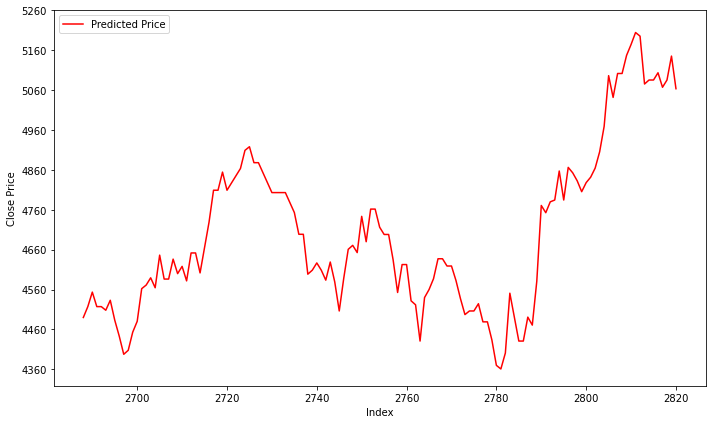

In [16]:
import matplotlib.pyplot as plt

# Assuming num_test is defined
predicted_price = obs["Close"].iloc[-(num_test):-1]


# Plot predicted vs real prices
plt.figure(figsize=(10, 6))

# Plot predicted prices
plt.plot(predicted_price.index, predicted_price, label='Predicted Price', color='red', linestyle='-')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()

# Set y-axis ticks with a step of 500
plt.yticks(range(int(predicted_price.min()), int(predicted_price.max()) + 100, 100))
plt.savefig(f"{ticker}_Prediction_Out.png")
# Show plot
plt.tight_layout()
plt.show()
